# **Predicting Blood Pressure Based on Key Cardiovascular Attributes**







**Group Name:** Group 3<br><br>

**Name(s) & ID(s) of Group Members:** 

*   Adem Truong (s3900998)
*   Carter Facey-Smith (s3907874)
*   Max Foord (s3888349)  <br><br>

### **Table of Contents** ###

*   Introduction
  *   Phase 1 Summary
  *   Report Overview
  *   Methodology Overview
  *   Notes
*   Statistical Modelling
*   Report Critique and Analysis
*   Summary and Conclusion
*   References

# **Introduction** #

#### **Phase 1 Summary** ####

In Phase 1 of the project we undertook the task of cleaning and preprocessing the Heart Failure Prediction dataset, before commencing with preliminary visualisation and analysis.
<br>

During analysis of the visualised data, we formed the opinion that there may have been a potential positive correlation between abnormal resting ECG categories and blood pressure, with ST slope being a possible influence regarding the blood pressure range.









#### **Report Overview** ####

We commenced the Phase 2 report by giving a brief summary of the project history through our Phase 1 findings above, before detailing the requisite modelling and analysis.

We began by analysing the outliers present in the data, specific outliers were deemed relevant to the integrity of the data and surveyed population so were kept in.

We then commenced fitting of our full model using least-squares based regression to examine the relationship between resting BP and other variables. After which, we used various graphs to examine same.

Finally we examine the results against our hypothesis and look for any indication of violations against the regression assumptions, noting that there were none and that our model seems to support our hypothesis.



#### **Methodology Overview** ####

In this report we utilise multiple linear regression, where we attempt to model the relationship between multiple explanatory variables against a single response variable by using a linear equation. 

Whilst doing this we attempt to avoid the pitfalls of overfitting the model and any potential for multicolinearity.

The regression line is fitted using the least-squares method, whereby the 'best fitting line' is calculated by minimising the sum of the squares of the vertical deviations from each data points to the line, i.e. how far the data point is from the line. 

This along with the variance and estimate of standard error allows us to examine the validity of the model and data.

# **Statistical Modelling** #


**Module Imports**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import io

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

heart_df = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

#### **Further Data Cleaning** ####

As previously discovered in Phase 1, clamp transformation was mentioned to deal with the outliers. However upon further investigation, we've realised that clamp transforming the data would not affect the model and have decided not to go ahead with it. The categorical column exerciseAngina will also be changed to be binary categorical.

In [ ]:
heart_df = heart_df.replace({'exerciseAngina' : { 'N' : 1, 'Y' : 0 }})

In [ ]:
heart_df.head(10)

,age,sex,chestPainType,restingBP,cholesterol,fastingBS,restingECG,maxHR,exerciseAngina,oldPeak,stSlope,heartDisease
0,40,M,ATA,140,289,0,Normal,172,1,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,1,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,1,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,0,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,1,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,1,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,1,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,1,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,0,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,1,0.0,Up,0


#### **Full Model Overview** ####

We begin by fitting a multiple linear regression that predicts `restingBP` using all of the available features.

First lets construct the regression formula. We will need to also manipulate the formula to fit the purpose of one-hot-encoding the categorical features.


In [ ]:
formula_string_indep_vars = ' + '.join(heart_df.drop(columns='restingBP').columns)
formula_string = 'restingBP ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  restingBP ~ age + sex + chestPainType + cholesterol + fastingBS + restingECG + maxHR + exerciseAngina + oldPeak + stSlope + heartDisease


In [ ]:
heart_df_encoded = pd.get_dummies(heart_df, drop_first=True)
heart_df_encoded.head()

,age,restingBP,cholesterol,fastingBS,maxHR,exerciseAngina,oldPeak,heartDisease,sex_M,chestPainType_ATA,chestPainType_NAP,chestPainType_TA,restingECG_Normal,restingECG_ST,stSlope_Flat,stSlope_Up
0,40,140,289,0,172,1,0.0,0,1,1,0,0,1,0,0,1
1,49,160,180,0,156,1,1.0,1,0,0,1,0,1,0,1,0
2,37,130,283,0,98,1,0.0,0,1,1,0,0,0,1,0,1
3,48,138,214,0,108,0,1.5,1,0,0,0,0,1,0,1,0
4,54,150,195,0,122,1,0.0,0,1,0,1,0,1,0,0,1


In [ ]:
formula_string_indep_vars_encoded = ' + '.join(heart_df_encoded.drop(columns='restingBP').columns)
formula_string_encoded = 'restingBP ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  restingBP ~ age + cholesterol + fastingBS + maxHR + exerciseAngina + oldPeak + heartDisease + sex_M + chestPainType_ATA + chestPainType_NAP + chestPainType_TA + restingECG_Normal + restingECG_ST + stSlope_Flat + stSlope_Up


In [ ]:
formula_string_encoded = formula_string_encoded + ' + age:restingBP + cholesterol:restingBP'

In [ ]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=heart_df_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              restingBP   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2950.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        06:58:30   Log-Likelihood:                -2099.2
No. Observations:                 917   AIC:                             4234.
Df Residuals:                     899   BIC:                             4321.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               129.30

The full model has an adjusted R-squared value of 0.982, meaning essentially 100% of the variance is explained by the model. We do notice the abundance of variables with p-values above the 5% threshold.

We will define a new data frame for actual resting blood pressure vs predicted resting blood pressure and the residuals for the full model, to use when plotting predicted values and the regression residuals.

In [ ]:
residuals_full = pd.DataFrame({'actual': heart_df_encoded['restingBP'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.head(10)

,actual,predicted,residual
0,140,138.273343,1.726657
1,160,153.842982,6.157018
2,130,129.341096,0.658904
3,138,135.997674,2.002326
4,150,148.209309,1.790691
5,120,119.892603,0.107397
6,130,129.068155,0.931845
7,110,111.514401,-1.514401
8,140,136.794780,3.205220
9,120,119.289317,0.710683


Let's plot actual resling blood pressure vs predicted resting blood pressure

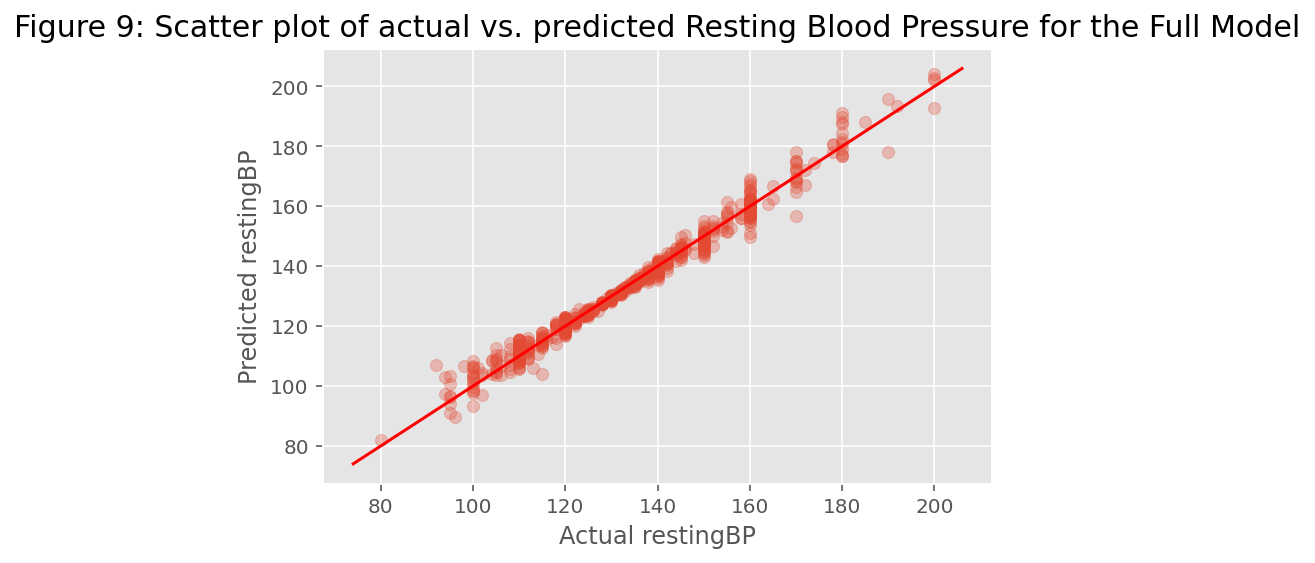

In [ ]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual restingBP');
plt.ylabel('Predicted restingBP');
plt.title('Figure 9: Scatter plot of actual vs. predicted Resting Blood Pressure for the Full Model', fontsize=15);
plt.show();

From Figure 9, we observe that the model produces predictions perfectly, following the trend line.

#### **Full model Diagnostic Checks** ####

We would like to check whether there are indications of violations of the regression assumptions, which are


1.   linearity of the relationship between target variable and the independent variables
2.   constant variance of the errors
3.   normality of the residual distribution
4.   statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted `restingBP`).

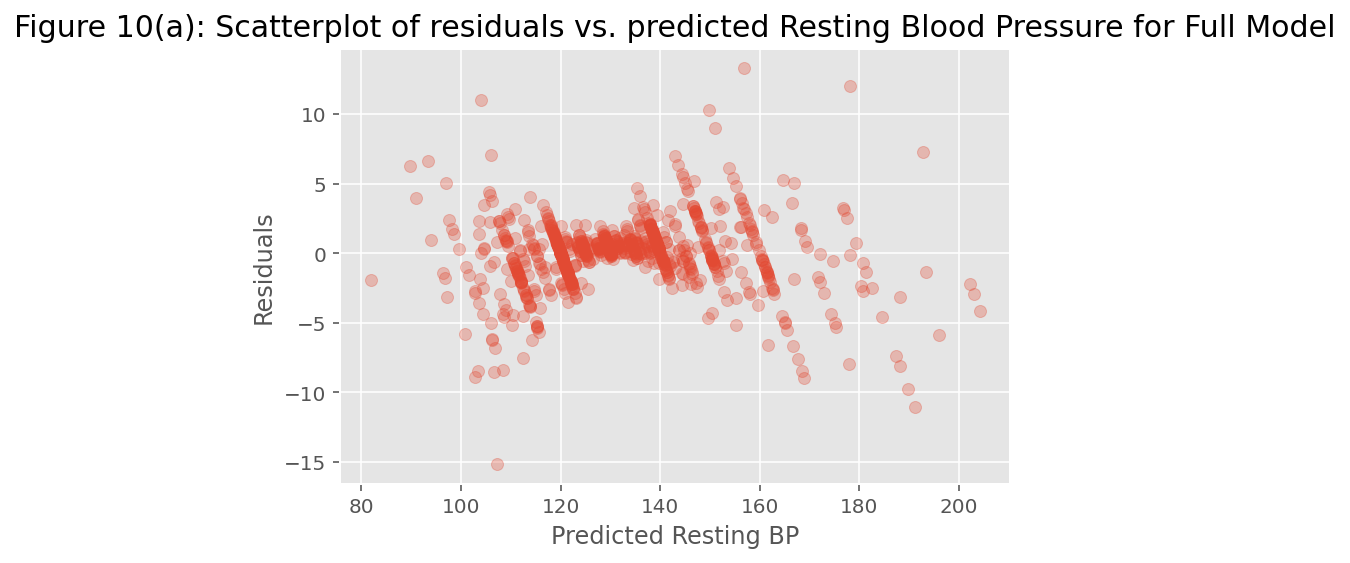

In [ ]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Resting BP');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted Resting Blood Pressure for Full Model', fontsize=15)
plt.show();

From Figure 10(a), we see that the residuals exhibit a mostly random pattern and center around 0, trending towards the mean of resting blood pressure. This pattern indicates that the constant variability assumption of linear regression is satisfied in this case.

Let's now plot actual age vs. residuals.

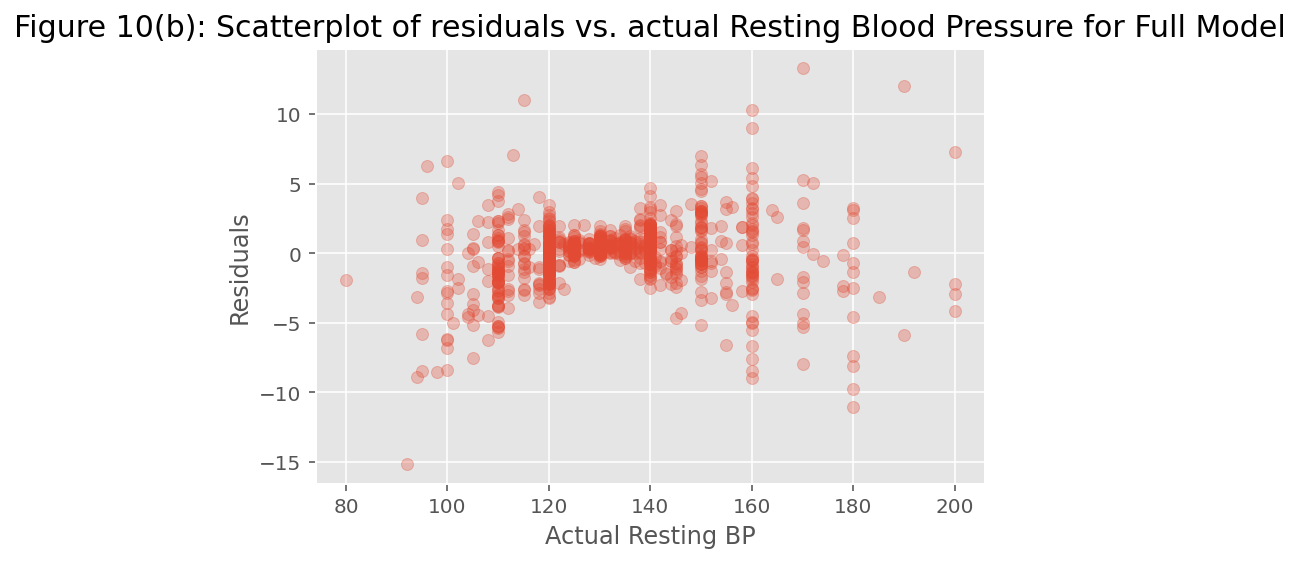

In [ ]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Resting BP');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual Resting Blood Pressure for Full Model', fontsize=15)
plt.show();

We notice that the model almost perfectly reproduces Figure 10(b), indicating the predictions are very accurate.

Let's overlay the histograms of actual vs. predicted age on the same plot.

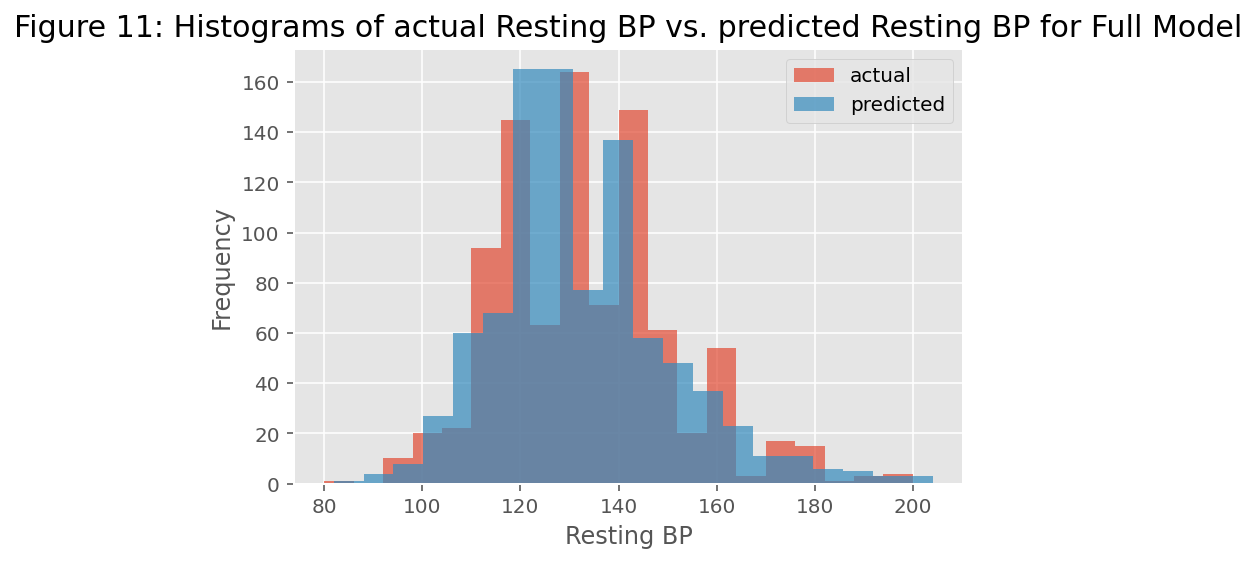

In [ ]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Resting BP');
plt.ylabel('Frequency');
plt.title('Figure 11: Histograms of actual Resting BP vs. predicted Resting BP for Full Model', fontsize=15);
plt.legend()
plt.show();

We notice that their distributions are very similar.

Let's now have look at the histogram of the residuals.

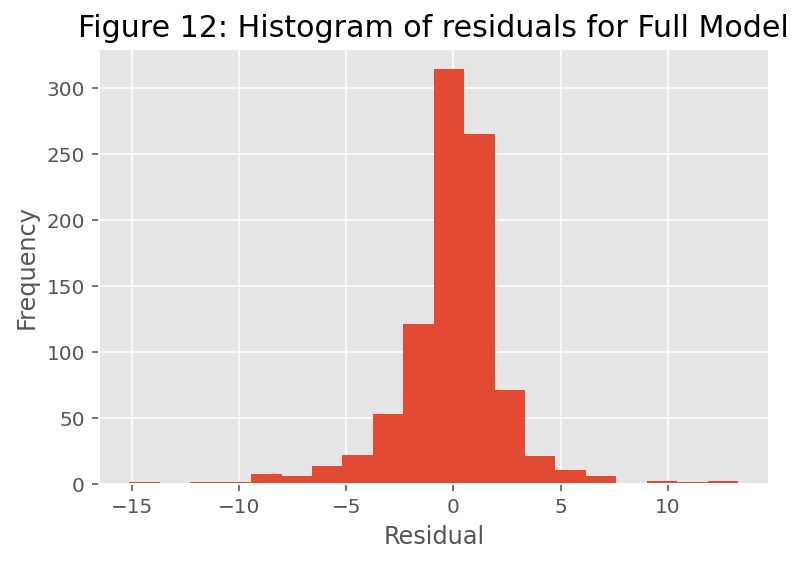

In [ ]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

From Figure 12, the historgram of residuals looks symmetric, though only slightly left-skewed. Therefore, signifies that the normality assumption of linear regression is not violated in this case.

#### **Backwards Feature Selection** ####

With the below code, we will now perform backwards feature selection using p-values.

In [ ]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=heart_df_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = heart_df_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "exerciseAngina" with p-value 0.9435

Removing term "restingECG_ST" with p-value 0.8768

Removing term "oldPeak" with p-value 0.7114

Removing term "maxHR" with p-value 0.7207

Removing term "restingECG_Normal" with p-value 0.6125

Removing term "chestPainType_NAP" with p-value 0.5332

Removing term "stSlope_Flat" with p-value 0.2648

Removing term "stSlope_Up" with p-value 0.4563

Removing term "chestPainType_ATA" with p-value 0.2239

Removing term "chestPainType_TA" with p-value 0.248

Removing term "fastingBS" with p-value 0.1783

***
                            OLS Regression Results                            
Dep. Variable:              restingBP   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     8390.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):          

#### **Reduced Model Overview** ####

Similar to the process in the Full Model Overview, we will define a new data frame for actual resting blood pressure vs predicted resting blood pressure and the residuals for the reduced model.

In [ ]:
residuals_reduced = pd.DataFrame({'actual': heart_df_encoded['restingBP'], 
                            'predicted': model_reduced_fitted.fittedvalues, 
                            'residual': model_reduced_fitted.resid})
residuals_reduced.head(10)

,actual,predicted,residual
0,140,138.404450,1.595550
1,160,153.602707,6.397293
2,130,129.452424,0.547576
3,138,135.840062,2.159938
4,150,147.857882,2.142118
5,120,119.631748,0.368252
6,130,129.191251,0.808749
7,110,111.592409,-1.592409
8,140,136.687295,3.312705
9,120,119.322582,0.677418


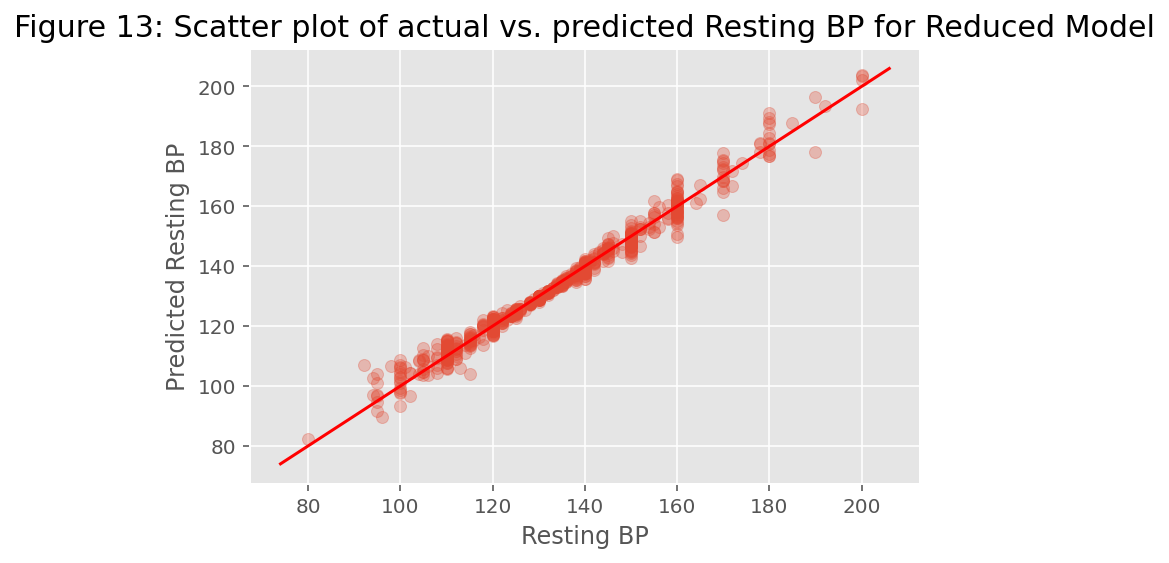

In [ ]:
# get a scatter plot
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Resting BP');
plt.ylabel('Predicted Resting BP');
plt.title('Figure 13: Scatter plot of actual vs. predicted Resting BP for Reduced Model', fontsize=15);
plt.show();

This reduced model returns the exact same adjusted R-squared value of 0.982, meaning the reduced model still explains in essence 100% of the variance, but with 11 less variables. As expected, all of the p-values hold significance at the 5% level.

#### **Reduced Model Diagnostic Checks** ####

Let's first get a scatter plot of residuals (as a function of predicted resting blood pressure).


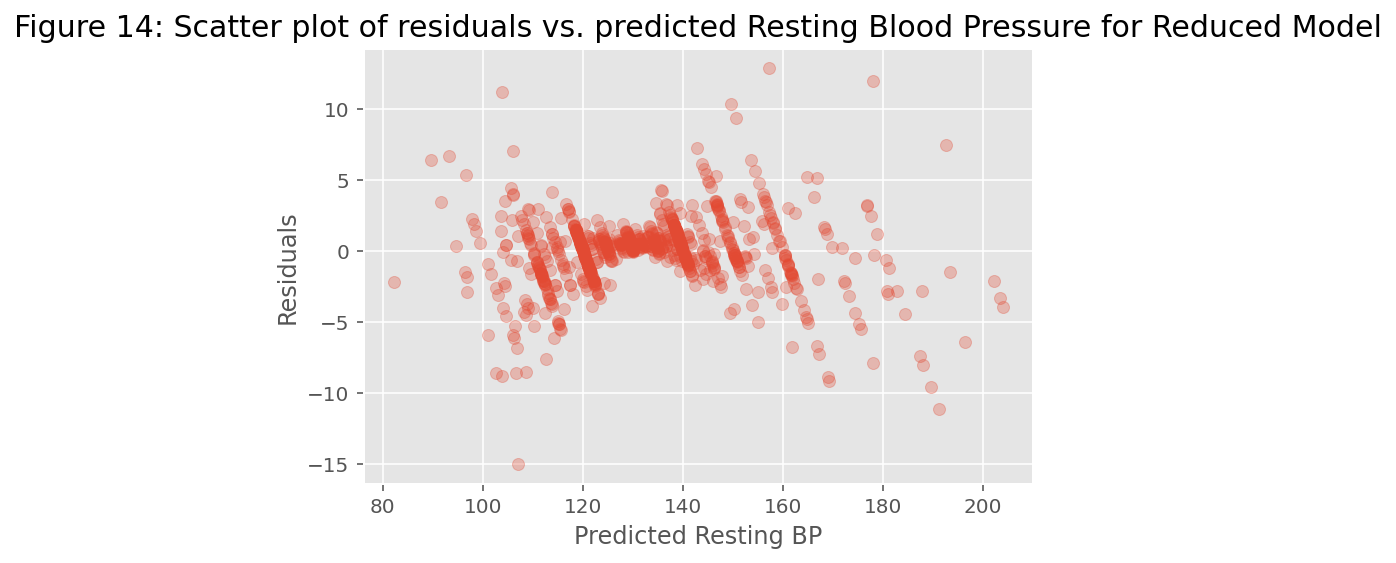

In [ ]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Resting BP');
plt.ylabel('Residuals')
plt.title('Figure 14: Scatter plot of residuals vs. predicted Resting Blood Pressure for Reduced Model', fontsize=15)
plt.show();

Figure 14 is exactly the same as Figure 10(a).

Let's now have look at the histogram of the residuals for the reduced model.

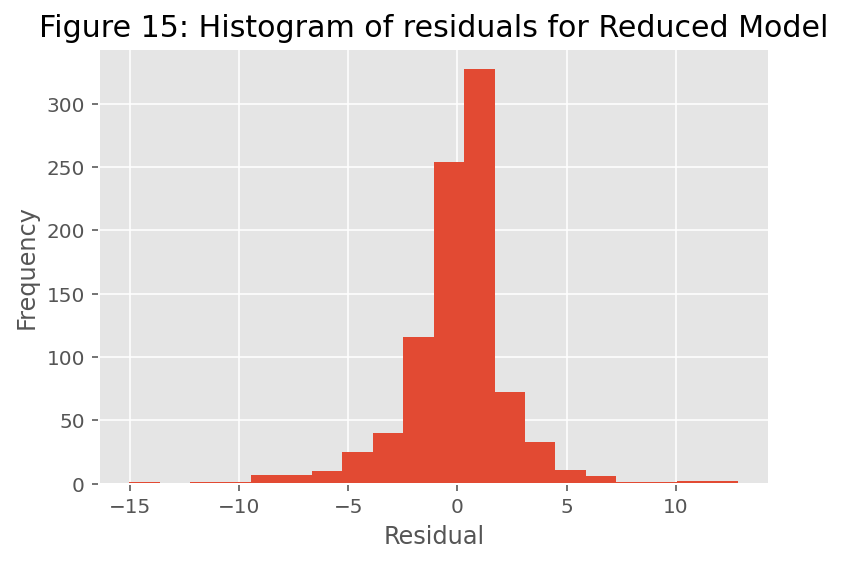

In [ ]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 15: Histogram of residuals for Reduced Model', fontsize = 15)
plt.show();

Again, we notice Figure 15 exhibits the same features as Figure 12 of the Full Model, which suggests that the residuals are normally distributed.

# **Critique and Limitations** #

As the dataset had been cleaned prior to our acqusition, along with our preliminary Phase 1 cleaning, the integrity of the data itself was high.

Although there are limitations specific to the method used, correlation and regression have certain key weaknesses in that:

- They only allow for consideration of linear relationships;
- Least-squares reggression is not innately resistant to outliers without detailed preprocessing;
- There is potential for unstudied variables to influence either the dependent variable or other independent variables; and
- Correlation does not innately imply causation.

Further to this, our dataset itself despite being clean could have inherent bias and limiatations caused by factors outside of our control, as we are unaware of the circumstances surround data collection and the validity of same.



# **Summary** #

#### **Phase 1 and 2 Summary** ####

Initially we began by standardising the naming conventions of all data features, along with examining the data for unique values and ranges to ensure data validity.

Values with null or invalid data were either standardised to the mean value of the feature or dropped, while The exerciseAngina column was converted to binary categorical. We then performed one-hot-encoding on the rest of the categorical columns.

We began the modelling by fitting a multiple linear regression that predicts restingBP using all of the available features. Using the values from the model we then retroactively selected the features that had a p value of < 0.05.

A new data frame for actual resting blood pressure vs predicted resting blood pressure was created to use when plotting predicted values and the regression residuals.



#### **Findings and conclusion** ####

An Adjusted R-squared value of 98% was achieved using all independant variables in the data. We were able to maintain this value, using 11 less variables using backwards variable selection with a p value cutoff of 0.05.

Thorough diagnostic checks with scatterplots indicate that the residuals mainly exhibit a random pattern, center around 0 and trend towards the mean of resting blood pressure. Such pattern indicates that the constant variability assumption of linear regression is satisfied. Furthermore, the residual histogram suggests there are no violations of the normality assumption of the residuals.

Our prediction that both age and cholesterol levels would have a strong correlation on resting blood pressure was supported by the multiple linear regression model.

# **References** # 

*   fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved October 1, 2021 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

